# Titanic - Machine Learning from Disaster

# Import

In [1]:
from pandas import Series 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re

import warnings
warnings.filterwarnings("ignore") 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#fix the package versions so that the experiments are reproducible
!pip freeze > requirements.txt

In [3]:
train = pd.read_csv('/kaggle/input/titanic/train.csv')
test= pd.read_csv('/kaggle/input/titanic/test.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# Description functions

In [4]:
#Function for rendering confusion_matrix
def show_confusion_matrix(y_true, y_pred):
    color_text = plt.get_cmap('PuBu')(0.95)
    class_names = ['Default', 'Non-Default']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="PuBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [5]:
#Function for displaying metrics for assessing the quality of the model
def all_metrics(y_true, y_pred, y_pred_prob):
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['Positive, P'] = [P,'default']
    dict_metric['Negative, N'] = [N,'non-default']
    dict_metric['True Positive, TP'] = [TP,'correctly identified default']
    dict_metric['True Negative, TN'] = [TN,'correctly identified non-default']
    dict_metric['False Positive, FP'] = [FP,'incorrectly identified default']
    dict_metric['False Negative, FN'] = [FN,'incorrectly identified non-default']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Precision = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Recall = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Harmonical mean of Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC AUC Score']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Value', 'Description'])
    display(temp_df) 

# Data

In [6]:
#Let's take a look at 5 random lines of training base
train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C
50,51,0,3,"Panula, Master. Juha Niilo",male,7.0,4,1,3101295,39.6875,NaN,S
332,333,0,1,"Graham, Mr. George Edward",male,38.0,0,1,PC 17582,153.4625,C91,S
847,848,0,3,"Markoff, Mr. Marin",male,35.0,0,0,349213,7.8958,NaN,C
511,512,0,3,"Webber, Mr. James",male,NaN,0,0,SOTON/OQ 3101316,8.0500,NaN,S


In [7]:
#Let's look at random 5 lines of the test base
test.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
381,1273,3,"Foley, Mr. Joseph",male,26.0,0,0,330910,7.8792,NaN,Q
156,1048,1,"Bird, Miss. Ellen",female,29.0,0,0,PC 17483,221.7792,C97,S
171,1063,3,"Zakarian, Mr. Ortin",male,27.0,0,0,2670,7.2250,NaN,C
49,941,3,"Coutts, Mrs. William (Winnie Minnie"" Treanor)""",female,36.0,0,2,C.A. 37671,15.9000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


More on the signs:
* PassengerId - identifier of passenger
* Survived - survival flag
* Pclass - ticket class
* Name - name of passenger
* Sex - sex (gender)
* Age - age in years
* SibSp - number of siblings / spouses aboard the Titanic
* Parch - number of parents / children aboard the Titanic
* Ticket - ticket number
* Fare - passenger fare
* Cabin - cabin number
* Embarked - port of Embarkation

In [8]:
#Let's look at random 5 lines of gender_submission
gender_submission.sample(5)

,PassengerId,Survived
415,1307,0
21,913,0
44,936,1
132,1024,1
114,1006,1


In [9]:
# Train base information
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# Test base information
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
# Train database statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
# Test database statistics
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Preprocessing

In [13]:
# Let's look at the distribution of the target variable
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [14]:
# the number of passes in the training base
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [15]:
# the number of passes in the testing base
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [16]:
# Let's look at the distribution of Age
train.Age.value_counts()

24.00    30
22.00    27
18.00    26
28.00    25
19.00    25
         ..
55.50     1
74.00     1
0.92      1
70.50     1
12.00     1
Name: Age, Length: 88, dtype: int64

Let's look the Age distribution depending on the Survived values

In [17]:
train[train.Survived == 0].Age.value_counts()

21.0    19
28.0    18
25.0    17
18.0    17
22.0    16
        ..
15.0     1
36.5     1
34.5     1
55.0     1
74.0     1
Name: Age, Length: 77, dtype: int64

In [18]:
train[train.Survived == 1].Age.value_counts()

24.00    15
36.00    11
35.00    11
27.00    11
22.00    11
         ..
43.00     1
0.92      1
55.00     1
12.00     1
0.67      1
Name: Age, Length: 65, dtype: int64

In [19]:
# replace the pass with the mean
train.Age = train.Age.fillna(train.Age.mean())
test.Age = test.Age.fillna(test.Age.mean())

In [20]:
# Let's look at the distribution of Cabin
train.Cabin.value_counts()

G6             4
C23 C25 C27    4
B96 B98        4
D              3
F2             3
              ..
C95            1
C87            1
E58            1
C49            1
B42            1
Name: Cabin, Length: 147, dtype: int64

Let's replace the Cabin values with the letter from the number of cabin (if it is present in both test and train), the blanks are "empty"

In [21]:
train['Cabin'] = train.Cabin.str.extract(pat='([A-Z])')
test['Cabin'] = test.Cabin.str.extract(pat='([A-Z])')

In [22]:
train['Cabin'] = train.Cabin.fillna('empty')
test['Cabin'] = test.Cabin.fillna('empty')

In [23]:
train.Cabin.unique()

array(['empty', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [24]:
test.Cabin.unique()

array(['empty', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

In [25]:
train[train.Cabin == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


In [26]:
train.Cabin = train.Cabin.apply(lambda s: 'empty' if s == 'T' else s)

In [27]:
# # Let's look at the distribution of Cabin
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [28]:
# delete two lines
train = train.dropna(axis = 0, subset=['Embarked'])

In [29]:
# replace the pass with the median in test dataset
test.Fare = test.Fare.fillna(test.Fare.median())

Let's take another look at the information about datasets after the changes.

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Cabin        889 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 90.3+ KB


In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        418 non-null    object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Passes removed

In [32]:
# we combine two signs of relatives into one
train['Num_family'] = train['SibSp'] + train['Parch']
test['Num_family'] = test['SibSp'] + test['Parch']

We split the signs into 3 lists (excl. PassengerID, Name)

In [33]:
num_cols = ['Age', 'Num_family', 'Fare']

cat_cols = ['Pclass', 'Ticket', 'Embarked', 'Cabin']

bin_cols = ['Sex']

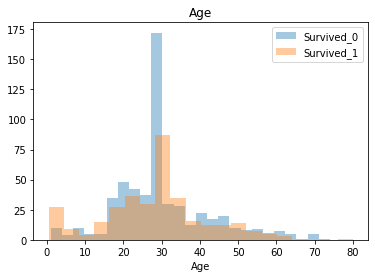

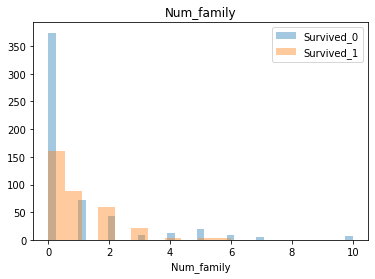

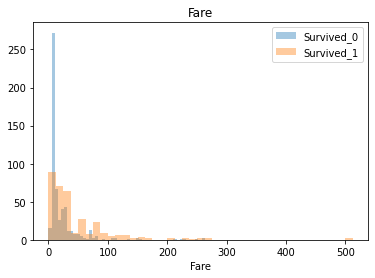

In [34]:
# Graphs of distributions of numerical features
for i in num_cols:
    plt.figure()
    sns.distplot(train[i][train.Survived == 0], kde = False, rug=False, label = 'Survived_0')
    sns.distplot(train[i][train.Survived == 1], kde = False, rug=False, label = 'Survived_1')
    plt.title(i)
    plt.legend()
    plt.show()

<AxesSubplot:>

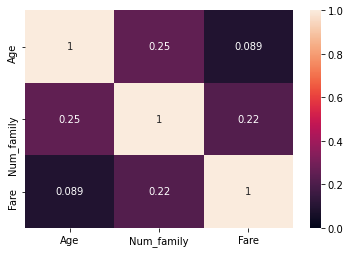

In [35]:
# heat map of numerical features
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot = True)

Age, Cabin, Sex, Embarked, Fare.

In [36]:
train.Age = train.Age // 5
test.Age = test.Age // 5

In [37]:
train['Cabin'] = LabelEncoder().fit_transform(train['Cabin'])
test['Cabin'] = LabelEncoder().fit_transform(test['Cabin'])

In [38]:
train['Sex'] = LabelEncoder().fit_transform(train['Sex'])
test['Sex'] = LabelEncoder().fit_transform(test['Sex'])

In [39]:
train.groupby('Survived')['Embarked'].value_counts()

Survived  Embarked
0         S           427
          C            75
          Q            47
1         S           217
          C            93
          Q            30
Name: Embarked, dtype: int64

In [40]:
Embarked_dict = {'S': 3, 'Q': 2, 'C': 1}

train.Embarked = train['Embarked'].map(Embarked_dict)
test.Embarked = test['Embarked'].map(Embarked_dict)

In [41]:
train[(train.Fare < 7) & (train.Survived == 1)].Fare.count()

2

In [42]:
train[(train.Fare < 7) & (train.Survived == 0)].Fare.count()

26

In [43]:
train.Fare = train.Fare.apply(lambda x: x//5 if x >= 7 else 0)
test.Fare = test.Fare.apply(lambda x: x//5 if x >= 7 else 0)

# Feature engineering

In [44]:
# new features
train['Parch_SibSp'] = train['Parch'] * train['SibSp']
test['Parch_SibSp'] = test['Parch'] * test['SibSp']

train['Age_and_Sex'] = train['Age'] * train['Sex']
test['Age_and_Sex'] = test['Age'] * test['Sex'] 

train['Num_family_in_degree_Sex'] = train['Num_family'] ** (train['Sex'] + 1)
test['Num_family_in_degree_Sex'] = test['Num_family'] ** (test['Sex'] + 1)

In [45]:
# We add new signs to the corresponding lists
num_cols.append('Parch_SibSp')
num_cols.append('Age_and_Sex')
num_cols.append('Num_family_in_degree_Sex')

In [46]:
# PClass distribution relative to Survived
train.groupby('Survived')['Pclass'].value_counts()

Survived  Pclass
0         3         372
          2          97
          1          80
1         1         134
          3         119
          2          87
Name: Pclass, dtype: int64

In [47]:
#new feature
train['Pclass_Sex'] = train['Pclass'] * (train['Sex'] + 1)
test['Pclass_Sex'] = test['Pclass'] * (test['Sex'] + 1)

In [48]:
# We add new sign to the corresponding list
cat_cols.append('Pclass_Sex')

In [49]:
# Pclass_Sex distribution relative to Survived
train.groupby('Survived')['Pclass_Sex'].value_counts()

Survived  Pclass_Sex
0         6             300
          4              91
          2              83
          3              72
          1               3
1         2             115
          1              89
          3              72
          6              47
          4              17
Name: Pclass_Sex, dtype: int64

In [50]:
# Num_family distribution relative to Survived
train.groupby('Survived')['Num_family'].value_counts()

Survived  Num_family
0         0             374
          1              72
          2              43
          5              19
          4              12
          3               8
          6               8
          10              7
          7               6
1         0             161
          1              89
          2              59
          3              21
          6               4
          4               3
          5               3
Name: Num_family, dtype: int64

In [51]:
# new feature
train['Alone'] = train['Num_family'].apply(lambda x: 1 if x == 0 else 0)
test['Alone'] = test['Num_family'].apply(lambda x: 1 if x == 0 else 0)

In [52]:
# We add new sign to the corresponding list
bin_cols.append('Alone')

In [53]:
# Ticket distribution relative to Survived
train.groupby('Survived')['Ticket'].value_counts()

Survived  Ticket          
0         347082              7
          CA. 2343            7
          3101295             6
          347088              6
          CA 2144             6
                             ..
1         STON/O2. 3101282    1
          STON/O2. 3101283    1
          SW/PP 751           1
          W./C. 14258         1
          WE/P 5735           1
Name: Ticket, Length: 729, dtype: int64

In [54]:
# Create an array of tickets containing "34" in the record
Contain_34 = train[train.Ticket.str.contains('34')].Ticket.values
Contain_34

array(['373450', '349909', '347742', '347082', '345763', '349909',
       '347077', '349216', '345764', '349253', '349237', 'C.A. 34651',
       '347088', 'S.P. 3464', '348123', '349208', '345767', '345779',
       '343275', '343276', '347466', 'W.E.P. 5734', '349245', '349215',
       '349207', '343120', '349249', '347082', '347061', '349241', '7534',
       '347081', 'CA. 2343', '347068', '347088', '347742', 'CA. 2343',
       '347077', '349247', '234604', '345770', 'CA. 2343', '347054',
       '349234', 'PP 4348', '347067', '347077', '347071', '347054',
       '347077', '347083', '347073', '347464', '345778', '349239',
       '345774', '349206', '349236', '349233', '9234', '349243', '347470',
       '349219', '234818', 'CA. 2343', '345364', '345764', '349225',
       '349237', '345783', '347088', '349909', '347069', '349227',
       '350034', '341826', '347064', '349222', '343095', '345773',
       '349254', '347080', 'A/4. 34244', '345769', '347076', '230434',
       'C.A. 34651', 

In [55]:
#new feature
train['Ticket_34'] = train['Ticket'].apply(lambda s: 1 if s in Contain_34 else 0)
test['Ticket_34'] = test['Ticket'].apply(lambda s: 1 if s in Contain_34 else 0)

In [56]:
# Ticket_34 distribution relative to Survived
train.groupby('Survived')['Ticket_34'].value_counts()

Survived  Ticket_34
0         0            416
          1            133
1         0            312
          1             28
Name: Ticket_34, dtype: int64

In [57]:
# Remove the Ticket attribute from the lists, Ticket_34 - add
cat_cols.remove('Ticket')
bin_cols.append('Ticket_34')

# Visualization and importance

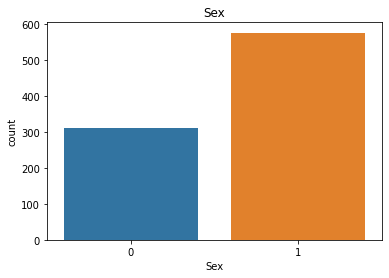

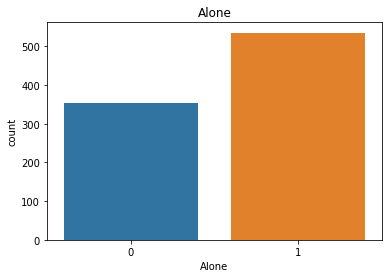

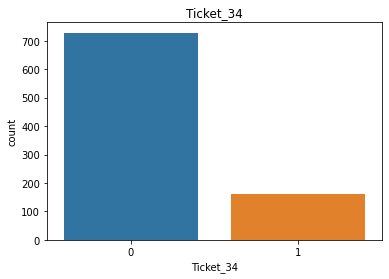

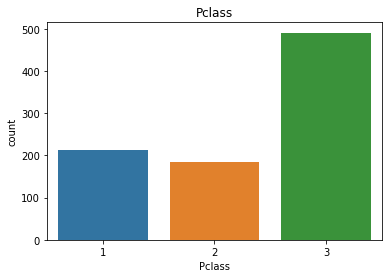

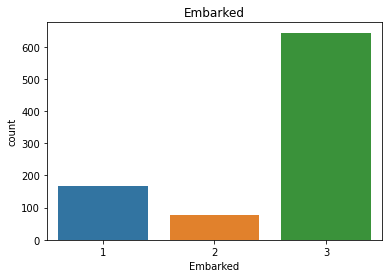

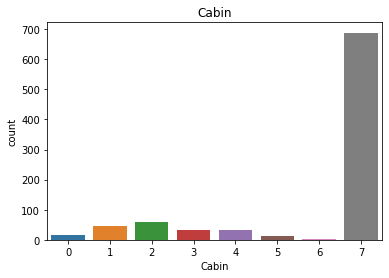

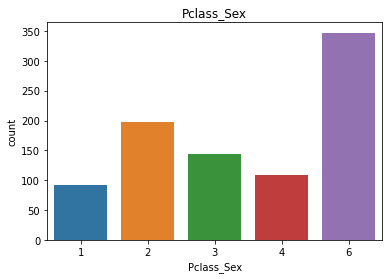

In [58]:
# Histograms of the distribution of binary and category features
for column in bin_cols+cat_cols:
    plt.figure()
    sns.countplot(train[column])
    plt.title(column)
    plt.show()

<AxesSubplot:>

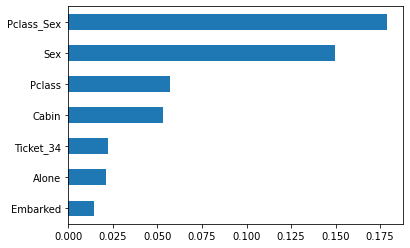

In [59]:
# Importance of binary and categorical variables
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['Survived'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Text(0.5, 0, 'F-value')

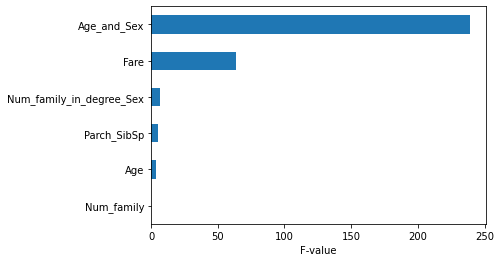

In [60]:
# Importance of numerical variables
imp_num = Series(f_classif(train[num_cols], train['Survived'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.xlabel('F-value')

In [61]:
# let's look at the absolute of correlation of features of the training base
corr_train = train.drop(['PassengerId', 'SibSp', 'Parch_SibSp'], axis = 1).corr().abs()
corr_train.style.background_gradient(cmap='coolwarm').set_precision(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Cabin,Embarked,Num_family,Age_and_Sex,Num_family_in_degree_Sex,Pclass_Sex,Alone,Ticket_34
Survived,1.000,0.336,0.542,0.067,0.083,0.259,0.290,0.170,0.018,0.461,0.087,0.528,0.206,0.202
Pclass,0.336,1.000,0.128,0.337,0.017,0.554,0.742,0.165,0.064,0.078,0.102,0.796,0.139,0.339
Sex,0.542,0.128,1.000,0.087,0.248,0.180,0.112,0.110,0.203,0.780,0.072,0.664,0.307,0.052
Age,0.067,0.337,0.087,1.000,0.173,0.098,0.250,0.020,0.247,0.574,0.169,0.199,0.170,0.116
Parch,0.083,0.017,0.248,0.173,1.000,0.218,0.034,0.040,0.783,0.272,0.427,0.150,0.583,0.092
Fare,0.259,0.554,0.180,0.098,0.218,1.000,0.528,0.224,0.218,0.104,0.113,0.473,0.275,0.164
Cabin,0.290,0.742,0.112,0.250,0.034,0.528,1.000,0.204,0.010,0.045,0.051,0.590,0.143,0.217
Embarked,0.170,0.165,0.110,0.020,0.040,0.224,0.204,1.000,0.067,0.063,0.076,0.178,0.063,0.206
Num_family,0.018,0.064,0.203,0.247,0.783,0.218,0.010,0.067,1.000,0.283,0.720,0.084,0.691,0.143
Age_and_Sex,0.461,0.078,0.780,0.574,0.272,0.104,0.045,0.063,0.283,1.000,0.069,0.361,0.321,0.012


In [62]:
# Remove the insignificant variable with high correlation
num_cols.remove('Num_family')

# Model for train_valid

In [63]:
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
X_cat

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [64]:
Y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
Y_cat

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

In [65]:
# Let's combine data from features of lists for model
X = np.hstack([train[num_cols], train[bin_cols].values, X_cat])
Y = train['Survived'].values

PassengerId = test['PassengerId']
test = np.hstack([test[num_cols], test[bin_cols].values, Y_cat])

In [66]:
# We divide the training set into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle = True)

In [67]:
# Set and train the model
model = RandomForestClassifier(random_state = 1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)

model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=1)

In [68]:
# Predicting the values of the validation base
Y_predict = model.predict(X_valid)
Y_predict_prob = model.predict_proba(X_valid)[:,1]

# Preliminary results

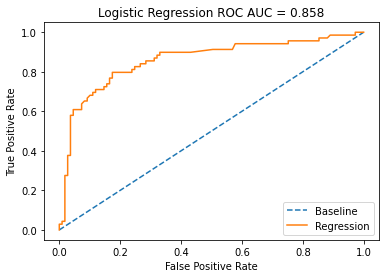

In [69]:
# Building a ROC curve
fpr, tpr, threshold = roc_curve(y_valid, Y_predict_prob)
roc_auc = roc_auc_score(y_valid, Y_predict_prob)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

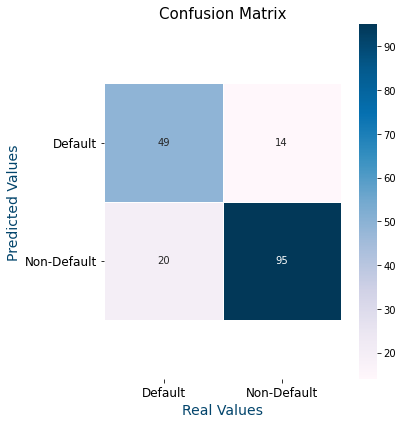

In [70]:
# Let's display confusion_matrix
show_confusion_matrix(y_valid, Y_predict)

In [71]:
# Output the quality metrics of the model
all_metrics(y_valid, Y_predict, Y_predict_prob)

,Value,Description
"Positive, P",69.000000,default
"Negative, N",109.000000,non-default
"True Positive, TP",49.000000,correctly identified default
"True Negative, TN",95.000000,correctly identified non-default
"False Positive, FP",14.000000,incorrectly identified default
"False Negative, FN",20.000000,incorrectly identified non-default
Accuracy,0.808989,Accuracy=(TP+TN)/(P+N)
Precision,0.777778,Precision = TP/(TP+FP)
Recall,0.710145,Recall = TP/P
F1-score,0.742424,Harmonical mean of Precision и Recall


# Model for train_test

In [72]:
# Set and train the model
main_model = RandomForestClassifier(random_state = 1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)

main_model.fit(X, Y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=1)

In [73]:
# Predicting the values of the testing base
y_pred_test = main_model.predict(test)
y_pred_prob_test = main_model.predict_proba(test)[:,1]

# Submission

In [74]:
my_gender_submission = pd.DataFrame({'PassengerId': PassengerId,
                              'Survived': y_pred_test})
my_gender_submission.to_csv('submission.csv', index=False)

my_gender_submission.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
